In [118]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, MaxPooling2D, Conv2DTranspose, Reshape, concatenate
from tensorflow.keras.models import Model, Sequential

tfd = tfp.distributions

In [263]:
data_size = 'small'
data_path = os.path.join('..', 'data', 'femnist', data_size)
x_train = np.load(f'../data/femnist/{data_size}/x_train.npy')
y_train = np.load(f'../data/femnist/{data_size}/y_train.npy')
y_train = to_categorical(y_train)
gid_train = np.load(f'../data/femnist/{data_size}/gid_train.npy')
x_test = np.load(f'../data/femnist/{data_size}/x_test.npy')
y_test = np.load(f'../data/femnist/{data_size}/y_test.npy')
y_test = to_categorical(y_test)
gid_test = np.load(f'../data/femnist/{data_size}/gid_test.npy')

x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.
x_test[x_test >= .5] = 1.
x_test[x_test < .5] = 0.

In [264]:
[x.dtype for x in [x_train, y_train, y_train, gid_train, x_test, y_test, y_test, gid_test]]

[dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('int32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('int32')]

In [265]:
x_train.shape, y_train.shape

((35535, 784), (35535, 62))

In [399]:
def var_posterior(args):
    mu, log_sigma = args
    posterior = tfd.MultivariateNormalDiag(
        loc=mu,  
        #scale_diag=tf.exp(log_sigma / 2)
        scale_diag=tf.nn.softplus(log_sigma + 0.55)
    )
    return posterior

## VAE

In [474]:
z_dim = 10

# Encoder
X = Input(shape=(784,))
x = Reshape(target_shape=(28,28,1))(X)
x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
x = Flatten()(x)
#x = Dense(512)(X)
mu = Dense(z_dim)(x)
log_sigma = Dense(z_dim)(x)

encoder = Model(inputs=X, outputs=[mu, log_sigma])

# Decoder
z = Input(shape=(z_dim,))
x = Dense(units=7*7*32, activation='relu')(z)
x = Reshape(target_shape=(7, 7, 32))(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(x)
# No activation
x = Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")(x)
x = tf.nn.sigmoid(x)
x_recon = Flatten()(x)
#x = Dense(512)(z)
#x_recon = Dense(784)(z)

decoder = Model(inputs=z, outputs=x_recon)

# VAE
X = Input(shape=(784,))
mu, log_sigma = encoder(X)
z = Lambda(lambda args: var_posterior(args).sample())([mu, log_sigma])
x_recon = decoder(z)
VAE = Model(inputs=X, outputs=x_recon)

In [466]:
# TODO: make better
batch_size = 400

def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    z_prior = tfd.MultivariateNormalDiag(
        loc=np.zeros((z_dim,), dtype=np.float32), 
        scale_diag=np.ones((z_dim,), dtype=np.float32))
    
    kl = tfd.kl_divergence(var_posterior([mu, log_sigma]), z_prior)
    #kl = z_prior.log_prob(var_posterior([mu, log_sigma]).sample())
    
    minibatch_factor = batch_size / x_train.shape[0]
    return recon + kl * minibatch_factor

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
VAE.compile(optimizer=optimizer, loss=vae_loss)

VAE.fit(x=x_train[:100000], y=x_train[:100000], batch_size=batch_size, epochs=1)

35535/35535 [==============================] - 22s 623us/sample - loss: 0.2143


In [467]:
VAE.summary()

Model: "model_176"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_230 (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
model_174 (Model)               [(None, 10), (None,  23956       input_230[0][0]                  
__________________________________________________________________________________________________
lambda_56 (Lambda)              (None, 10)           0           model_174[1][0]                  
                                                                 model_174[1][1]                  
__________________________________________________________________________________________________
model_175 (Model)               (None, 784)          54497       lambda_56[0][0]          

In [468]:
encoder(x_train[:2])[1]

<tf.Tensor: id=478123, shape=(2, 10), dtype=float32, numpy=
array([[-0.30681145, -0.21224268, -0.2819363 , -0.4138584 , -0.14393419,
        -0.06950907, -0.1124088 , -0.31358206,  0.00221568, -0.34418556],
       [-0.3068115 , -0.21224268, -0.28193632, -0.41385838, -0.14393419,
        -0.06950908, -0.1124088 , -0.31358206,  0.00221567, -0.34418556]],
      dtype=float32)>

In [469]:
decoder(encoder(x_train[:2]))

<tf.Tensor: id=478268, shape=(2, 784), dtype=float32, numpy=
array([[0.95666933, 0.9928971 , 0.99702096, ..., 0.99982977, 0.99942946,
        0.993613  ],
       [0.95666933, 0.9928971 , 0.99702096, ..., 0.99982977, 0.99942946,
        0.993613  ]], dtype=float32)>

In [470]:
latent_means = encoder(x_train[:1000])[1]
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA()
pca_latent_means = pca.fit_transform(latent_means)
#tsne = TSNE()
#tsne_latent_means = tsne.fit_transform(latent_means)

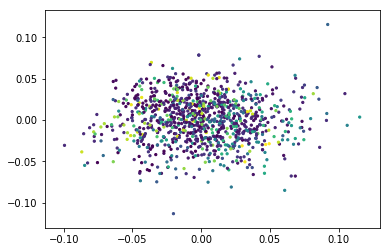

In [471]:
plt.scatter(pca_latent_means[:,0],pca_latent_means[:,1], s=5, c=y_train[:1000].argmax(axis=1))

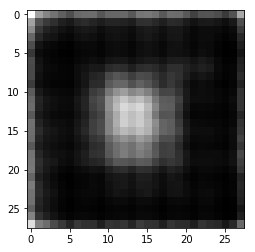

In [472]:
gen = decoder(
    tfd.MultivariateNormalDiag(
        loc=np.zeros((1,z_dim), dtype=np.float32), 
        scale_diag=np.ones((1,z_dim), dtype=np.float32)).sample())

# `1 -` to reverse color
plt.imshow(1 - gen.numpy().reshape((28,28)),
    cmap='gray');

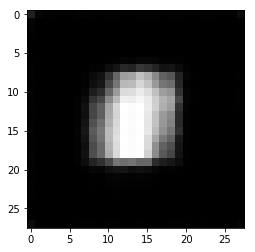

In [473]:
# `1 -` to reverse color
plt.imshow(1 - decoder(encoder(x_train[:2]))[1].numpy().reshape((28,28)),
    cmap='gray');

In [207]:
[x.shape for x in VAE.get_weights()]

[(3, 3, 1, 32),
 (32,),
 (3, 3, 32, 64),
 (64,),
 (2304, 10),
 (10,),
 (2304, 10),
 (10,),
 (10, 1568),
 (1568,),
 (3, 3, 64, 32),
 (64,),
 (3, 3, 32, 64),
 (32,),
 (3, 3, 1, 32),
 (1,)]

## MLP CVAE

In [475]:
z_dim = 20

# Encoder
X = Input(shape=(784,))
cond = Input(shape=(62,))
encoder_inputs = concatenate([X, cond])
x = Dense(512, activation='relu')(encoder_inputs)
mu = Dense(z_dim, activation='linear')(x)
log_sigma = Dense(z_dim, activation='linear')(x)

encoder = Model(inputs=[X, cond], outputs=[mu, log_sigma])

# Decoder
z = Input(shape=(z_dim,))
z_cond = concatenate([z, cond])
x = Dense(512, activation='relu')(z_cond)
decoder_out = Dense(784+62, activation='sigmoid')(x)
x_recon, y_recon = tf.split(decoder_out, [784, 62], 1)

decoder = Model(inputs=[z, cond], outputs=[x_recon, y_recon])

# CVAE
X = Input(shape=(784,))
cond = Input(shape=(62,))
mu, log_sigma = encoder([X, cond])
z = Lambda(lambda args: var_posterior(args).sample())([mu, log_sigma])
x_recon, y_recon = decoder([z, cond])

CVAE = Model(inputs=[X, cond], outputs=[x_recon, y_recon])

In [476]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)
loss_fn = tf.keras.losses.BinaryCrossentropy()
CVAE.compile(optimizer=optimizer, loss=loss_fn)

In [477]:
CVAE.fit(x=[x_train,y_train], y=[x_train,y_train], batch_size=200, epochs=10)

Epoch 1/10
35535/35535 [==============================] - 5s 128us/sample - loss: 0.1120 - model_181_loss: 0.0376
Epoch 2/10
35535/35535 [==============================] - 4s 109us/sample - loss: 0.0456 - model_181_loss: 0.0011
Epoch 3/10
35535/35535 [==============================] - 4s 124us/sample - loss: 0.0352 - model_181_loss: 3.9483e-04
Epoch 4/10
35535/35535 [==============================] - 4s 125us/sample - loss: 0.0302 - model_181_loss: 2.4809e-04
Epoch 5/10
35535/35535 [==============================] - 4s 115us/sample - loss: 0.0273 - model_181_loss: 1.7024e-04
Epoch 6/10
35535/35535 [==============================] - 5s 129us/sample - loss: 0.0253 - model_181_loss: 1.2510e-04
Epoch 7/10
35535/35535 [==============================] - 4s 118us/sample - loss: 0.0242 - model_181_loss: 1.0286e-04
Epoch 8/10
35535/35535 [==============================] - 4s 124us/sample - loss: 0.0230 - model_181_loss: 8.4183e-05
Epoch 9/10
35535/35535 [==============================] - 5s 129

In [478]:
def generate_class(y_conds):
    return decoder([
        tfd.Normal(loc=np.zeros((1,z_dim), dtype=np.float32), scale=np.ones((1,z_dim), dtype=np.float32)).sample(), 
        to_categorical(np.array(y_conds, dtype=np.float32), num_classes=62)])

In [479]:
labels = string.digits + string.ascii_uppercase + string.ascii_lowercase 

A


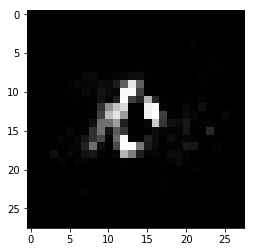

In [505]:
y_conds = [10]
idx = 0
print(labels[y_conds[idx]])
# `1 -` to reverse color
plt.imshow(1 - generate_class(y_conds)[idx].numpy().reshape((28,28)),
    cmap='gray');

## CNN CVAE